## Summary
An in-memory spatial database based on a KD-Tree has been constructed to facilitate spatial range queries and nearest neighbor queries for the 'Assignment2-2012_BIT_POI.csv' dataset. The results of these queries, along with the efficiency of the KD-Tree spatial index, are presented respectively. Subsequently, brute-force query functions were implemented to compare the efficiency of queries with and without the KD-Tree spatial index, with the results shown.
***

## Solutions

### 1. Building a K-D Tree in-memory spatial database
The KD-Tree is considered an extension of binary trees into K-dimensional space, with a construction and search process similar to binary trees. The splitting strategy involves alternately using each dimension's feature for splitting. Since our query functions only require latitude and longitude, the KD-Tree we construct is two-dimensional. Assuming the data points are (x, y) coordinates, for a series of (x, y) points, the KD-Tree first splits the data points into left and right subtrees based on the first dimension feature (x), then splits the left subtree and right subtree based on the second dimension feature (y) alternately, until all data points are split. Here is a simple example:

Assuming we have these data points: <center>`[(5, 4), (2, 3), (9, 6), (1, 7), (4, 2), (8, 1), (10, 3)]`</center>

We start building the KD tree with depth 0. We choose the x-axis as the initial splitting axiowing structure:

For the x-axis, we sort the data points and get:  <center>`[(1, 7), (2, 3), (4, 2), (5, 4), (8, 1), (9, 6), (10, 3)]`</center>

After sorting, we choose the median of the x-axis as the root node, which is (5, 4). The left subtree contains the first three points, and the right subtree contains the last three points.

For the left subtree, we choose the y-axis as the splitting axis. Sorting the data points in the left subtree along the y-axis, we get: <center>`[(4, 2), (2, 3), (1, 7)]`</center>

After sorting, we choose the median of the y-axis as the root node of the left subtree, which is (2, 3). The left subtree contains (4, 2), and the right subtree contains (1, 7).

For the right subtree, we choose the y-axis as the splitting axis. Sorting the data points in the right subtree along the y-axis, we get: <center>`[(10, 3), (9, 6), (8, 1)]`</center>

After sorting, we choose the median of the y-axis as the root node of the right subtree, which is (9, 6). The left subtree contains (8, 1), and the right subtree contains (10, 3).

We continue this process recursively to build the KD tree until all data points are placed in the tree. Finally, we get a KD tree containing all data points, with the following structure:
<div align='center'>
           (5, 4)<br>
         /$~~~~~~~$\<br>
     (2, 3)$~~~~~~$(9, 6)<br>
     /$~~~~~~$\ $~~~$ /$~~~~~~$ \<br>
(1, 7)$~~$(4, 2)$~$(8, 1)$~~$(10, 3)<br>
</div>


A more visually intuitive demonstration:
<table style="border: 0.5px solid #D3D3D3; border-collapse: collapse;">
    <tr style="border-bottom: 0.5px solid #D3D3D3;">
        <td style="border-right: 0.5px solid #D3D3D3;"><img src='Figure.png'></td>
        <td><img src='Figure_1.png'></td>
    </tr>
    <tr style="border-bottom: 0.5px solid #D3D3D3;">
        <td style="border-right: 0.5px solid #D3D3D3;"><center>Original Data Distribution</center></td>
        <td><center>The first split of the KD tree is done along the first dimension feature, which is the x-axis.</center>
            <center>We choose (5, 4) as the root node for the first split, dividing the entire set of data points </center></center>
            <center>into two parts, namely the left and right subtrees.</center></td>
    </tr>
    <tr style="border-bottom: 0.5px solid #D3D3D3;">
        <td style="border-right: 0.5px solid #D3D3D3;"><img src='Figure_2.png'></td><td><img src='Figure_4.png'></td>
    </tr>
    <tr style="border-bottom: 0.5px solid #D3D3D3;">
        <td style="border-right: 0.5px solid #D3D3D3;">
            <center>Along the second dimension feature, which is the y-axis, perform another split on the left</center>
            <center>subtree. Choose (2,3) as the root node of the left subtree and divide the left subtree into two parts.</center></td>
        <td><center>Alternate between splitting along the x-axis or y-axis until all data points in the first left</center>
            <center>subtree are divided.</center></td>
    </tr>
    <tr style="border-bottom: 0.5px solid #D3D3D3;">
        <td style="border-right: 0.5px solid #D3D3D3;"><img src='Figure_5.png'></td><td><img src='Figure_7.png'></td>
    </tr>
    <t style="border-bottom: 0.5px solid #D3D3D3;"r>
        <td style="border-right: 0.5px solid #D3D3D3;"><center>Use the same method to split the right subtree.</center></td>
        <td><center>The final structure of the KD-Tree.</center></td>
    </tr>
</table>

##### ***Code in Python***

In [ ]:
def build_kd_tree(self, points, depth=0):  
    if len(points) == 0:  
    return None  
    k = len(points[0])  
    axis = depth % k  
    points_sorted = sorted(points, key=lambda x: x[axis])  
    median = len(points_sorted) // 2  
    node = {  
        'point': points_sorted[median],  
        'left': self.build_kd_tree(points_sorted[:median], depth + 1),  
        'right': self.build_kd_tree(points_sorted[median + 1:], depth + 1)  
    }  
    return node  

### 2. Query functions based on K-D Tree
The following query functions based on "1. Building a K-D Tree in-memory spatial database" answer the two questions "How many restaurants are within 500 meters of the south door of BIT?" and "What's the nearest ATM around the Central Building of BIT?" The complete code is also provided.TT

#### 2.1 Spatial Range Query  
A `query_ball_point` method is defined to implement range queries. This method takes a query point and a query radius as parameters, and returns a list of indexes of points within the specified range.

Tt` method starts by traversing the KD-tree recursively from the root node. During traversal, determine the child nodes that need to be further traversed based on the division axis of the node and the coordinates of the query point. If the point represented by the node is within the query range, add its index to the result list. If the distance between the division axis of the node and the coordinate axis of the query point is less than the query radius, continue traversing the child nodes of the node. By using this method, we can find the indexes of all points within the specified range and return them to the user. 

##### ***Code in Python***

In [208]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import time

class KDTree:
    def __init__(self, points):
        self.points = points
        self.tree = self.build_kd_tree(points)

    def build_kd_tree(self, points, depth=0):
        if len(points) == 0:
            return None
        
        k = len(points[0])
        axis = depth % k
        points_sorted = sorted(points, key=lambda x: x[axis])
        
        median = len(points_sorted) // 2
        node = { 
            'point': points_sorted[median],
            'left': self.build_kd_tree(points_sorted[:median], depth + 1),
            'right': self.build_kd_tree(points_sorted[median + 1:], depth + 1)
        }
        return node

    def query_ball_point(self, query_point, radius):
        indices = []
        self._query_ball_point(self.tree, query_point, radius, indices, depth=0)
        return indices

    def _query_ball_point(self, node, query_point, radius, indices, depth):
        if node is None:
            return
        
        k = len(query_point)
        axis = depth % k
        axis_dist = abs(query_point[axis] - node['point'][axis])

        if axis_dist <= radius:
            dist = self.haversine(query_point, node['point'])
            if dist <= radius:
                indices.append(self.points.index(node['point']))

        if query_point[axis] - radius < node['point'][axis]:
            self._query_ball_point(node['left'], query_point, radius, indices, depth + 1)
        if query_point[axis] + radius > node['point'][axis]:
            self._query_ball_point(node['right'], query_point, radius, indices, depth + 1)
    
    def haversine(self, point1, point2):
        lon1, lat1 = point1
        lon2, lat2 = point2
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a)) 
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles
        return c * r

def IndexBuilding(file_path):
    # Read the dataset
    data = pd.read_csv(file_path)
    # Extract longitude and latitude information
    points = data[['wgs_lng', 'wgs_lat']].values.tolist()
    # Build the KD tree index
    kdtree = KDTree(points)
    return kdtree

# Modify the range query function
def range_query(kdtree, query_point, radius_km):
    # Perform the range query
    indices = kdtree.query_ball_point(query_point, radius_km)
    # Get the indexes, names, and type codes of the points within the specified radius
    result_indices = []
    for idx in indices:
        point = kdtree.points[idx]
        name = data.iloc[idx]['name']
        type_code = str(data.iloc[idx]['type_code'])  # Convert type_code to string type
        if type_code.startswith('5'):
            result_indices.append((idx, name, type_code))
    return result_indices

# Build the index using the custom index-building function
start_time = time.time()
index = IndexBuilding('Assignment2-2012_BIT_POI.csv')
index_build_time2 = time.time() - start_time

# Define a range query function
query_point = [116.310, 39.955]
radius_km = 0.5

# Perform the range query
start_time = time.time()
result_indices = range_query(index, query_point, radius_km)
range_query_time = time.time() - start_time

# Output result
df1 = pd.DataFrame(result_indices, columns=['Index', 'Name', 'Type Code'])
print(f"Number of points within {radius_km} kilometers of the query point: {len(df1)}")
df1

Number of points within 0.5 kilometers of the query point: 39


,Index,Name,Type Code
0,131,雕刻时光（魏公村路）,50500
1,28,桥咖啡,50500
2,254,乡村啤酒屋,50100
3,135,北京外国语大学学生食堂,50100
4,248,阿曼尼萨汗美食城,50121
5,253,渝州家厨（魏公村店）,50102
6,67,周黑鸭（中友大厦北）,50000
7,257,北京外国语大学教工餐厅,50100
8,136,北京外国语大学清真餐厅,50121
9,260,咕咕派（北外店）,50000


_The query time for the index construction time and the query time for this range query run._

In [209]:
time_consumed1 = {"Index construction Time (s)": [index_build_time2], "Query Time (s)": [range_query_time]}
df1 = pd.DataFrame(time_consumed1)
df1

,Index construction Time (s),Query Time (s)
0,0.020609,0.101272


#### 2.2 Nearest Neighbour Query
Utilize the previously defined `build_kd_tree` function to construct a KD tree class. Then, call the `query_nearest_neighbor` method of the KD tree, passing the query point (`query_point`) and type code prefix (`type_code_prefix`) as parameters. Start the recursive query from the root node, comparing the current axis coordinate of the query point with the current node's point to select the next subtree to visit. At each node, calculate the distance between the query point and the current node, and compare it with the current best distance. If the distance is closer and meets the type code prefix requirement, update the best point and best distance. Prune based on the current best distance: if the distance from the query point's current axis coordinate to the points in the subtree's region of the current node is less than the current best distance, pruning can be done, and there is no need to continue searching the subtree. Finally, return the nearest neighbor point and its distance.

##### ***Code in Python***

In [213]:
import pandas as pd
import numpy as np
from tabulate import tabulate

class KDTree:
    def __init__(self, points):
        # Initialize the KDTree with the given points
        self.points = points
        self.root = self.build_kd_tree(points)

    def build_kd_tree(self, points, depth=0):
        # Recursively build the KDTree
        if len(points) == 0:
            return None

        k = len(points[0])
        axis = depth % k
        points_sorted = sorted(points, key=lambda x: x[axis])

        median = len(points_sorted) // 2
        node = {
            'point': points_sorted[median],
            'left': self.build_kd_tree(points_sorted[:median], depth + 1),
            'right': self.build_kd_tree(points_sorted[median + 1:], depth + 1)
        }
        return node

    def query_nearest_neighbor(self, query_point, type_code_prefix):
        # Find the nearest neighbor to the query_point with the given type code prefix
        best_point, best_dist = self._query_nearest_neighbor(self.root, query_point, 0, None, float('inf'), type_code_prefix)
        return best_point, best_dist

    def _query_nearest_neighbor(self, node, query_point, depth, best_point, best_dist, type_code_prefix):
        # Helper function to recursively find the nearest neighbor
        if node is None:
            return best_point, best_dist

        k = len(query_point)
        axis = depth % k

        next_branch = None
        opposite_branch = None

        if query_point[axis] < node['point'][axis]:
            next_branch = node['left']
            opposite_branch = node['right']
        else:
            next_branch = node['right']
            opposite_branch = node['left']

        best_point, best_dist = self._query_nearest_neighbor(next_branch, query_point, depth + 1, best_point, best_dist, type_code_prefix)

        if best_dist is None or self.haversine(query_point, (node['point'][0], node['point'][1])) < best_dist:
            if str(node['point'][3]).startswith(type_code_prefix):
                best_point = node['point']
                best_dist = self.haversine(query_point, (node['point'][0], node['point'][1]))

        if best_dist is None or abs(query_point[axis] - node['point'][axis]) < best_dist:
            best_point, best_dist = self._query_nearest_neighbor(opposite_branch, query_point, depth + 1, best_point, best_dist, type_code_prefix)

        return best_point, best_dist

    def haversine(self, point1, point2):
        # Calculate the great circle distance between two points
        lon1, lat1 = point1
        lon2, lat2 = point2
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a)) 
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles
        return c * r

# Define a function to build the index
def IndexBuilding(file_path):
    data = pd.read_csv(file_path)
    points = list(zip(data['wgs_lat'], data['wgs_lng'], data['name'], data['type_code']))
    kdtree = KDTree(points)
    return kdtree

# Build the index using the IndexBuilding function
start_time = time.time()
index = IndexBuilding('Assignment2-2012_BIT_POI.csv')
index_build_time = time.time() - start_time

# Define a function for nearest neighbor query
def NNQuery(query_point, type_code_prefix, index):
    return index.query_nearest_neighbor(query_point, type_code_prefix)

# Perform the nearest neighbor query
query_point = (39.958, 116.311)
type_code_prefix = "1603"
start_time = time.time()
nearest_neighbor, dist = NNQuery(query_point, type_code_prefix, index)
nearest_query_time = time.time() - start_time
nearest_neighbor_data = [(nearest_neighbor[:2][0], nearest_neighbor[:2][1], nearest_neighbor[2], nearest_neighbor[3], dist)]
df2 = pd.DataFrame(nearest_neighbor_data, columns=['Latitude', 'Longitude', 'Name', 'Type Code', 'Distance (km)'])
df2

,Latitude,Longitude,Name,Type Code,Distance (km)
0,39.956512,116.310542,招商银行ＡＴＭ（魏公村路８号院东北）,160306,0.089307


_The query time for the index construction time and the query time for this nearest neighbour query run._

In [214]:
time_consumed2 = {"Index construction Time (s)": [index_build_time1], "Query Time (s)": [nearest_query_time]}
df0 = pd.DataFrame(time_consumed2)
df0

,Index construction Time (s),Query Time (s)
0,0.01604,0.038112


### 3. Efficiency of the K-D Tree spatial index

1. Index Building Efficiency

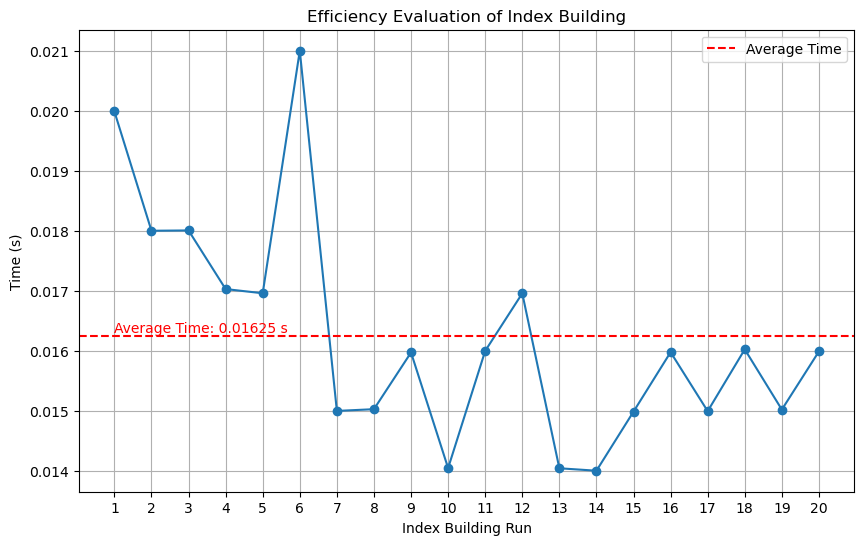

In [144]:
class KDTree:
    def __init__(self, points):
        self.points = points
        self.root = self.build_kd_tree(points)

    def build_kd_tree(self, points, depth=0):
        if len(points) == 0:
            return None

        k = len(points[0])
        axis = depth % k
        points_sorted = sorted(points, key=lambda x: x[axis])

        median = len(points_sorted) // 2
        node = {
            'point': points_sorted[median],
            'left': self.build_kd_tree(points_sorted[:median], depth + 1),
            'right': self.build_kd_tree(points_sorted[median + 1:], depth + 1)
        }
        return node

# Create an empty KDTree object
kdtree = KDTree([])

# Define a function for building the index
def IndexBuilding(file_path):
    data = pd.read_csv(file_path)
    points = list(zip(data['wgs_lat'], data['wgs_lng'], data['name'], data['type_code']))
    return points

# Test the efficiency of index building
index_building_times = []
for _ in range(20):
    start_time = time.time()
    points = IndexBuilding('Assignment2-2012_BIT_POI.csv')
    kdtree = KDTree(points)  # Create KDTree object here
    end_time = time.time()
    index_building_times.append(end_time - start_time)

# Calculate the average index building time
average_index_building_time = sum(index_building_times) / len(index_building_times)

# Plot the efficiency evaluation result
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), index_building_times, marker='o')
plt.axhline(y=average_index_building_time, color='r', linestyle='--', label='Average Time')
plt.text(1, average_index_building_time, f'Average Time: {average_index_building_time:.5f} s', color='r', va='bottom')
plt.xticks(range(1, 21, 1))
plt.xlabel('Index Building Run')
plt.ylabel('Time (s)')
plt.title('Efficiency Evaluation of Index Building')
plt.legend()
plt.grid(True)
plt.show()

2. Range Query Efficiency

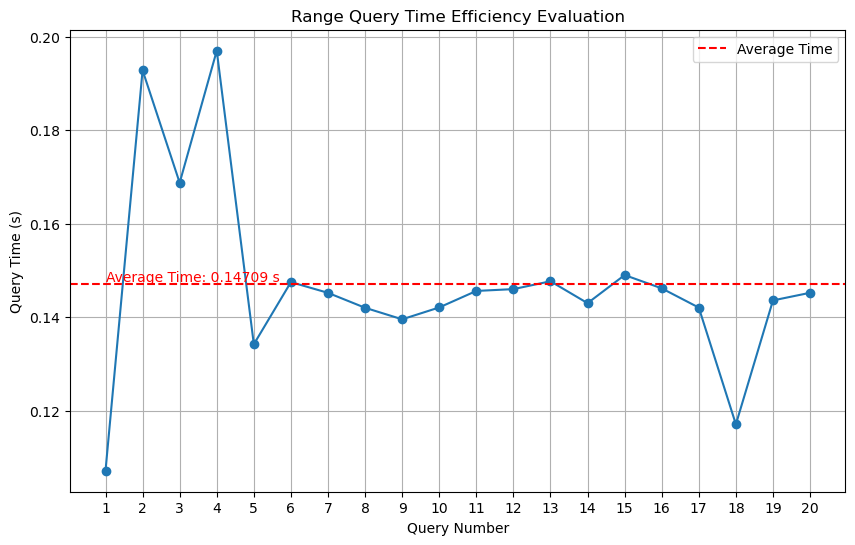

In [211]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Your KDTree implementation

# Define a range query function
def range_query(kdtree, query_point, radius_km):
    # Perform the range query
    indices = kdtree.query_ball_point(query_point, radius_km)
    # Get the indexes, names, and type codes of the points within the specified radius
    result_indices = []
    for idx in indices:
        point = kdtree.points[idx]
        name = data.iloc[idx]['name']
        type_code = str(data.iloc[idx]['type_code'])  # Convert type_code to string type
        if type_code.startswith('5'):
            result_indices.append((idx, name, type_code))
    return result_indices

# Build the index using the custom index-building function
index = IndexBuilding('Assignment2-2012_BIT_POI.csv')

# Perform 20 range queries
query_point = [116.310, 39.955]
radius_km = 0.5
query_times_1 = []
for _ in range(20):
    start_time = time.time()
    result_indices = range_query(index, query_point, radius_km)
    query_time = time.time() - start_time
    query_times_1.append(query_time)

# Calculate the average index building time
average_range_query_time = sum(query_times_1) / len(query_times_1)

# Plot the query times
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), query_times_1, marker='o')
plt.axhline(y=average_range_query_time, color='r', linestyle='--', label='Average Time')
plt.text(1, average_range_query_time, f'Average Time: {average_range_query_time:.5f} s', color='r', va='bottom')
plt.xticks(range(1, 21, 1))
plt.xlabel('Query Number')
plt.ylabel('Query Time (s)')
plt.title('Range Query Time Efficiency Evaluation')
plt.legend()
plt.grid(True)
plt.show()

3. Nearest Neighbour Query Efficiency

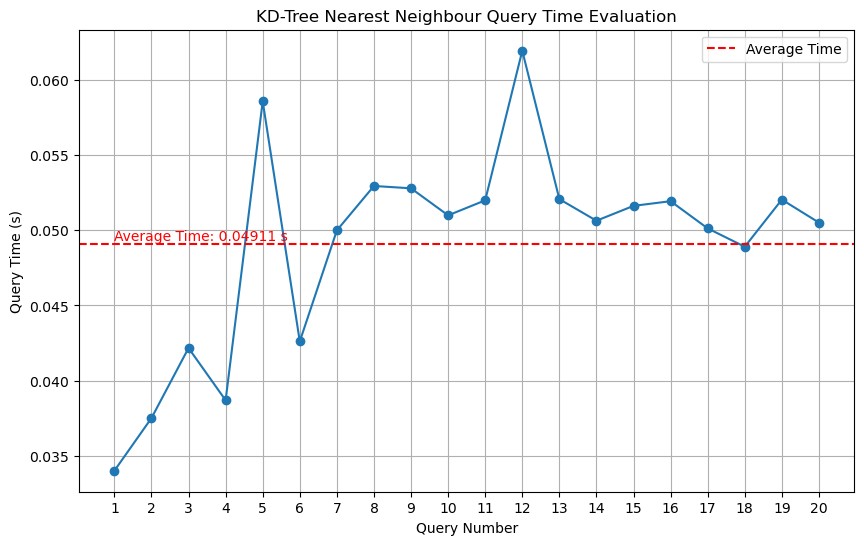

In [215]:
import time
import matplotlib.pyplot as plt

# Define a nearest neighbor query function with time recording
def NNQuery(query_point, type_code_prefix, index):
    start_time = time.time()
    nearest_neighbor, dist = index.query_nearest_neighbor(query_point, type_code_prefix)
    end_time = time.time()
    query_time = end_time - start_time
    return nearest_neighbor, dist, query_time

# Run 20 queries and record the time
query_times_2 = []
for query_num in range(1, 21):
    nearest_neighbor, dist, query_time = NNQuery(query_point, type_code_prefix, index)
    query_times_2.append(query_time)

# Calculate the average index building time
average_query_times = sum(query_times_2) / len(query_times_2)

# Plot the query time results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), query_times_2, marker='o')
plt.axhline(y=average_query_times, color='r', linestyle='--', label='Average Time')
plt.text(1, average_query_times, f'Average Time: {average_query_times:.5f} s', color='r', va='bottom')
plt.xticks(range(1, 21, 1))
plt.xlabel('Query Number')
plt.ylabel('Query Time (s)')
plt.title('KD-Tree Nearest Neighbour Query Time Evaluation')
plt.legend()
plt.grid(True)
plt.show()

***
## The Brute-Force Query Functions

In [30]:
import pandas as pd
from geopy.distance import geodesic

def RangeScan(query_range, type_code_prefix_1, file_path):
    query_point, radius = query_range
    data = pd.read_csv(file_path)
    points_within_radius = []
    count = 0  # Counter for points within radius

    for index, row in data.iterrows():
        dist = geodesic((row['wgs_lat'], row['wgs_lng']), (query_point[1], query_point[0])).meters
        type_code = str(row['type_code'])  # Convert type_code to string for comparison
        if dist <= radius and type_code.startswith(str(type_code_prefix_1)):
            points_within_radius.append((index, row['name'], row['type_code']))
            count += 1

    return points_within_radius, count

def NNScan(query_point, type_code_prefix_2, file_path):
    data = pd.read_csv(file_path)
    min_dist = float('inf')
    nearest_point = None

    for index, row in data.iterrows():
        type_code = str(row['type_code'])  # Convert type_code to string for comparison
        if type_code.startswith(str(type_code_prefix_2)):
            dist = geodesic((row['wgs_lat'], row['wgs_lng']), (query_point[1], query_point[0])).meters
            if dist < min_dist:
                min_dist = dist
                nearest_point = (index, row['name'], row['type_code'])

    return [nearest_point] if nearest_point is not None else []

# Example usage
query_range = ([116.310, 39.955], 500)  # BIT south door and 500 meters radius
type_code_prefix_1 = 5
type_code_prefix_2 = 1603
file_path = 'Assignment2-2012_BIT_POI.csv'

_The result of the Brute-Force range query is consistent with that of K-D Tree range query._

In [33]:
# Range query
res_range, count = RangeScan(query_range, type_code_prefix_1, file_path)
range_query_data = [(index, name, type_code) for index, name, type_code in res_range]
df_range_query = pd.DataFrame(range_query_data, columns=['Index', 'Name', 'Type Code'])
df_range_query

,Index,Name,Type Code
0,8,老自行车咖啡馆,50500
1,18,北京晋南建梅主食店,50000
2,27,花舞陕一边,50115
3,28,桥咖啡,50500
4,33,浩日沁蒙古餐厅,50100
5,41,Ａ８,50400
6,62,万记麻辣烫（魏公村店）,50100
7,63,九亿（魏公村店）,50100
8,65,大才子面馆（魏公村店）,50100
9,67,周黑鸭（中友大厦北）,50000


_The result of the Brute-Force nearest neighbor query is consistent with that of K-D Tree nearest neighbour query._

In [35]:
# Nearest neighbor query
query_point = [116.311, 39.958]  # BIT central building
res_nn = NNScan(query_point, type_code_prefix_2, file_path)
nn_query_data = [(index, name, type_code) for index, name, type_code in res_nn]
df_nn_query = pd.DataFrame(nn_query_data, columns=['Index', 'Name', 'Type Code'])
df_nn_query

,Index,Name,Type Code
0,1120,招商银行ＡＴＭ（魏公村路８号院东北）,160306


***
## A Demonstration On Efficiency Of Different Queries With/Without The Spatial Index

### 1. Spatial range query

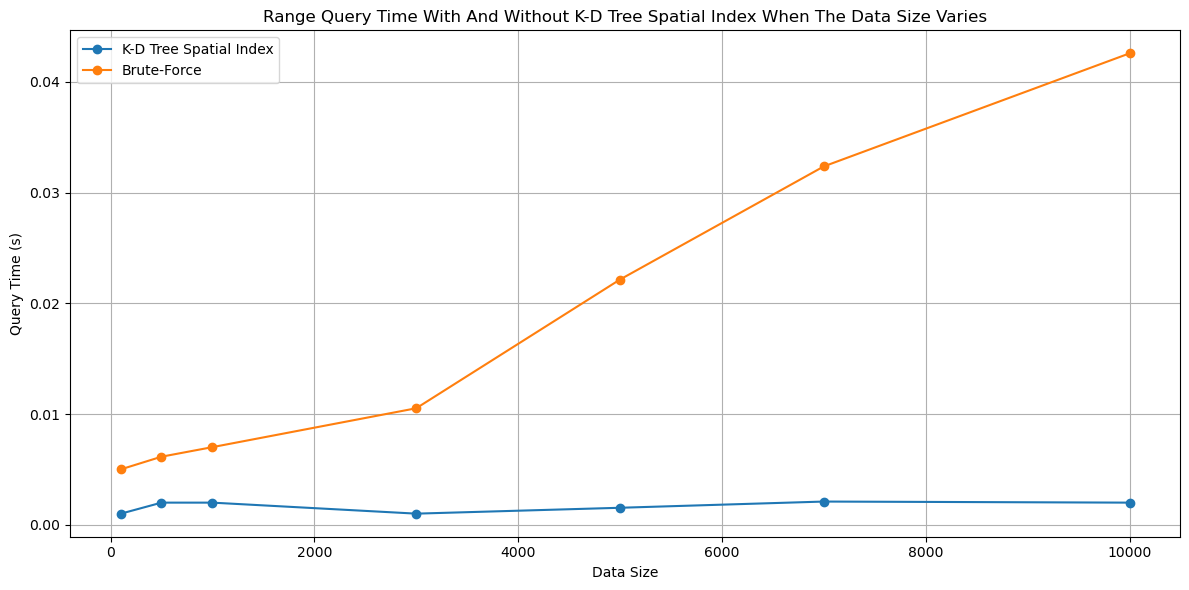

In [230]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def RangeScan(query_range, type_code_prefix_1, file_path):
    wgs_lng_min, wgs_lat_min, wgs_lng_max, wgs_lat_max = query_range
    data = pd.read_csv(file_path)
    points_within_range = data[(data['wgs_lng'] >= wgs_lng_min) & 
                                (data['wgs_lng'] <= wgs_lng_max) & 
                                (data['wgs_lat'] >= wgs_lat_min) & 
                                (data['wgs_lat'] <= wgs_lat_max) & 
                                (data['type_code'].astype(str).str.startswith(type_code_prefix_1))]
    return points_within_range

def IndexBuilding(file_path):
    data = pd.read_csv('Assignment2-2012_BIT_POI.csv')
    return data

def range_query(index, query_point, radius_km):
    wgs_lng, wgs_lat = query_point
    data = index
    points_within_radius = data[((data['wgs_lng'] - wgs_lng)**2 + (data['wgs_lat'] - wgs_lat)**2)**0.5 <= radius_km]
    return points_within_radius

# Define the query range and type code prefix
query_range = [116.310, 39.955, 116.33, 39.97]
type_code_prefix_1 = '5'

# Create different sizes of test datasets
data_sizes = [100, 500, 1000, 3000, 5000, 7000, 10000]
query_times_range_query = []
query_times_ranges_scan = []

for size in data_sizes:
    # Create a test dataset
    test_data = pd.DataFrame({
        'name': ['Point{}'.format(i) for i in range(size)],
        'type_code': np.random.randint(1, 2000, size=size),
        'wgs_lat': np.random.uniform(39.9, 40.0, size=size),
        'wgs_lng': np.random.uniform(116.3, 116.4, size=size)
    })
    test_data.to_csv('test_data_{}.csv'.format(size), index=False)
    
    # Build the index
    index = IndexBuilding('test_data_{}.csv'.format(size))

    # Perform range query
    query_point = [116.310, 39.955]
    radius_km = 0.05
    start_time = time.time()
    result_indices = range_query(index, query_point, radius_km)
    range_query_time = time.time() - start_time

    query_times_range_query.append((size, range_query_time))

    # Run the query and calculate the query time
    start_time = time.time()
    RangeScan(query_range, type_code_prefix_1, 'test_data_{}.csv'.format(size))
    end_time = time.time()
    query_times_ranges_scan.append((size, end_time - start_time))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(*zip(*query_times_range_query), marker='o', label='K-D Tree Spatial Index')
plt.plot(*zip(*query_times_ranges_scan), marker='o', label='Brute-Force')

plt.xlabel('Data Size')
plt.ylabel('Query Time (s)')
plt.title('Range Query Time With And Without K-D Tree Spatial Index When The Data Size Varies')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 2. Nearest neighbour query

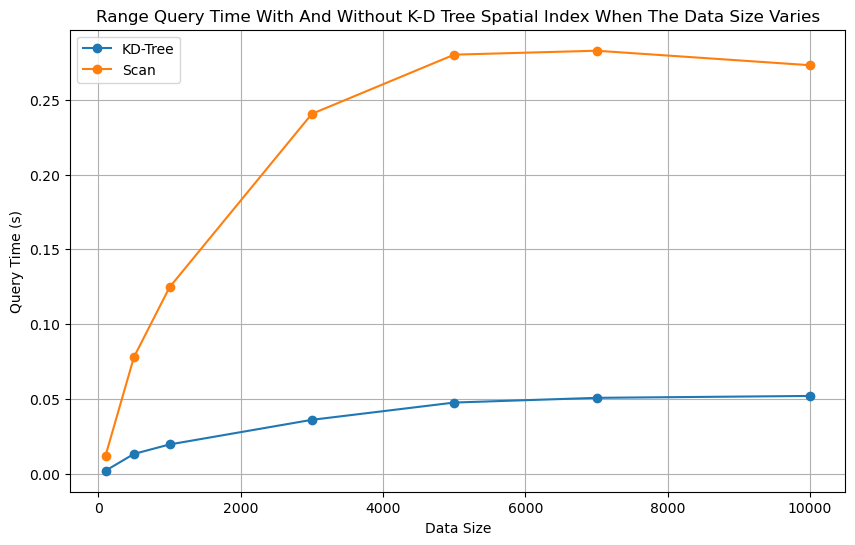

In [233]:
import pandas as pd
from geopy.distance import geodesic
import time
import matplotlib.pyplot as plt

# Define a function to build the index
def IndexBuilding(file_path):
    data = pd.read_csv(file_path)
    points = list(zip(data['wgs_lat'], data['wgs_lng'], data['name'], data['type_code']))
    kdtree = KDTree(points)
    return kdtree

# Define a function for nearest neighbor query
def NNQuery(query_point, type_code_prefix, index):
    return index.query_nearest_neighbor(query_point, type_code_prefix)

# Define a function to evaluate query time for different data sizes
def EvaluateQueryTime(data_sizes):
    query_times = []
    for size in data_sizes:
        # Generate test datasets
        data = pd.read_csv('Assignment2-2012_BIT_POI.csv')  
        points = list(zip(data['wgs_lat'], data['wgs_lng'], data['name'], data['type_code']))
        data_subset = points[:size]

        # Build the index
        kdtree = KDTree(data_subset)

        # Perform the nearest neighbor query
        query_point = (39.958, 116.311)
        type_code_prefix = "1603"
        start_time = time.time()
        nearest_neighbor, dist = NNQuery(query_point, type_code_prefix, kdtree)
        query_time = time.time() - start_time

        query_times.append(query_time)
    return query_times

# Define data sizes for evaluation
data_sizes = [100, 500, 1000, 3000, 5000, 7000, 10000]

# Evaluate query time for different data sizes
query_times_kd_tree = EvaluateQueryTime(data_sizes)

# Plot the results for KD-Tree
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, query_times_kd_tree, marker='o', label='KD-Tree')

# Define a function for the nearest neighbor query using scan
def NNScan(query_point, type_code_prefix_2, data):
    start_time = time.time()
    min_dist = float('inf')
    nearest_point = None

    for index, row in data.iterrows():
        type_code = str(row['type_code'])
        if type_code.startswith(str(type_code_prefix_2)):
            dist = geodesic((row['wgs_lat'], row['wgs_lng']), (query_point[1], query_point[0])).meters
            if dist < min_dist:
                min_dist = dist
                nearest_point = (index, row['name'], row['type_code'])

    end_time = time.time()
    query_time = end_time - start_time
    return query_time

# Generate test datasets
datasets = {}
for size in data_sizes:
    data = pd.read_csv('Assignment2-2012_BIT_POI.csv')  
    datasets[size] = data.head(size)

# Run queries for each dataset and record query times
query_point = [116.311, 39.958]  # BIT central building
type_code_prefix_2 = 1603
query_times_scan = {}
for size, data in datasets.items():
    query_times_scan[size] = NNScan(query_point, type_code_prefix_2, data)

# Plot the results for Scan
plt.plot(query_times_scan.keys(), query_times_scan.values(), marker='o', label='Scan')

# Finalize the plot
plt.xlabel('Data Size')
plt.ylabel('Query Time (s)')
plt.title('Range Query Time With And Without K-D Tree Spatial Index When The Data Size Varies')
plt.legend()
plt.grid(True)
plt.show()